This notebook is set up for the IBM Capstone Project through Coursera

In [1]:
import pandas as pd
import numpy as np
print ('Hello Capstone Project Course')

Hello Capstone Project Course


# Introduction

   New York City is one of the most diverse cities in the world. Being a focal point of the USA for any individual in other countries since at least the 1880s, the "Big Apple" has been more than welcoming of other cultures. With roughly 36.8% of the population born outside of the USA today, it is no coincidence that 800 different languages are spoken in the city. The diversity in the city has had an influence on food, fashion, pop culture, and sport.
     
   With soccer being the most popular sport in the world and the vast amount of cultures in NYC, it makes opening a new soccer shop in the city a realistic opportunity. The question is where exactly. Would it be better in Queens, where the most languages are spoken in the world, or in Manhattan where a professional soccer team plays, or somewhere else entirely? That is what this project will attempt to answer by observing where soccer is the most popular in the city and determine if there are any stores associated with soccer in the vicinity.

# Data

  The data being utilized to answer this question can be found below:
  
  - New York City latitude and longitude data can be found at this link
    https://cocl.us/new_york_dataset
  - The location and popularity of soccer fields, sports bars, and sporting goods stores will be found through the use of Foursquare API.


In [2]:
# Import the necessary libraries
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import seaborn as sns
from bs4 import BeautifulSoup

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [3]:
#Upload Data
def new_york_json_data():
    url='https://cocl.us/new_york_dataset'
    req=requests.get(url).json()
    # all data is present in features label
    features=req['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [4]:
ny_data = new_york_json_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### Create a map of New York City 

In [5]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [6]:
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(ny_data['Latitude'], ny_data['Longitude'], ny_data['Borough'], ny_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Foursquare API

In [7]:
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXX' # your Foursquare Secret
ACCESS_TOKEN = 'XXXXXXXXXXXXXXXXXXXXXX' # your FourSquare Access Token
VERSION = 'XXXXXXXX'
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TIDCTBYJFENFVEDEX531UDZBUQNRPU13XO0WS434TLCSALPC
CLIENT_SECRET:4YXEWQ0NZKOEFN25X3EFDHVVF3ZKE02HDCL1EZPJK4IJ3LNR


In [8]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))
categoryId = '4cce455aebf7b749d5e191f5' #soccer field
url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&ll={},{}&oauth_token={}&categoryId={}&v={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, ACCESS_TOKEN, categoryId, VERSION, LIMIT)
url

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


'https://api.foursquare.com/v2/venues/search?&client_id=TIDCTBYJFENFVEDEX531UDZBUQNRPU13XO0WS434TLCSALPC&client_secret=4YXEWQ0NZKOEFN25X3EFDHVVF3ZKE02HDCL1EZPJK4IJ3LNR&ll=40.7127281,-74.0060152&oauth_token=TEF1ULUY3LD1YP0XBLRMGC0GTZ420ONWUR5EFBWCFPXVBMG0&categoryId=4cce455aebf7b749d5e191f5&v=20180604&limit=100'

In [9]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ff0e798c94739757d92e42f'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 0}}],
 'response': {'venues': [{'id': '4bccd305fb84c9b62a1a213e',
    'name': 'Randalls Island Field',
    'location': {'address': 'Triborough Bridge Trail',
     'lat': 40.78366134243987,
     'lng': -73.92864843002606,
     'labeledLatLngs': [{'label': 'display',
       'lat': 40.78366134243987,
       'lng': -73.92864843002606}],
     'distance': 10243,
     'postalCode': '10035',
     'cc': 'US',
     'city': 'New York',
     'state': 'NY',
     'country': 'United States',
     'formattedAddress': ['Triborough Bridge Trail', 'New York, NY 10035']},
    'categories': [{'id': '4bf58dd8d48988d15f941735',
      'name': 'Field',
      'pluralName': 'Fields',
      'shortName': 'Field',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/field_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-16096234

In [10]:
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

<ipython-input-10-a1687cb1d013>:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  dataframe = json_normalize(venues)


,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,venuePage.id
0,4bccd305fb84c9b62a1a213e,Randalls Island Field,"[{'id': '4bf58dd8d48988d15f941735', 'name': 'F...",v-1609623448,False,Triborough Bridge Trail,40.783661,-73.928648,"[{'label': 'display', 'lat': 40.78366134243987...",10243,10035,US,New York,NY,United States,"[Triborough Bridge Trail, New York, NY 10035]",NaN,NaN
1,4a2be949f964a520ee961fe3,Battery Park City Ballfields,"[{'id': '4bf58dd8d48988d1e8941735', 'name': 'B...",v-1609623448,False,West St.,40.715979,-74.013604,"[{'label': 'display', 'lat': 40.71597881620529...",735,10282,US,New York,NY,United States,"[West St., New York, NY 10282]",NaN,NaN
2,4e712365899834bb2a26d7d9,Fords Middle School Soccer Field,"[{'id': '4cce455aebf7b749d5e191f5', 'name': 'S...",v-1609623448,False,NaN,40.541128,-74.322938,"[{'label': 'display', 'lat': 40.54112786101585...",32891,NaN,US,NaN,New Jersey,United States,[New Jersey],NaN,NaN
3,5186b7d7498e9e0ae6102568,Jim Brown Field - Manhasset Valley Park,"[{'id': '4cce455aebf7b749d5e191f5', 'name': 'S...",v-1609623448,False,NaN,40.790275,-73.705907,"[{'label': 'display', 'lat': 40.79027487295193...",26739,NaN,US,Manhasset,NY,United States,"[Manhasset, NY]",NaN,NaN
4,56795eb5498ec34bf96c7743,Metuchen Sports Center,"[{'id': '4cce455aebf7b749d5e191f5', 'name': 'S...",v-1609623448,False,302 High St,40.533190,-74.373209,"[{'label': 'display', 'lat': 40.5331897735007,...",36905,08840,US,Metuchen,NJ,United States,"[302 High St, Metuchen, NJ 08840]",NaN,NaN


In [11]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id
0,Randalls Island Field,Field,Triborough Bridge Trail,40.783661,-73.928648,"[{'label': 'display', 'lat': 40.78366134243987...",10243,10035,US,New York,NY,United States,"[Triborough Bridge Trail, New York, NY 10035]",NaN,4bccd305fb84c9b62a1a213e
1,Battery Park City Ballfields,Baseball Field,West St.,40.715979,-74.013604,"[{'label': 'display', 'lat': 40.71597881620529...",735,10282,US,New York,NY,United States,"[West St., New York, NY 10282]",NaN,4a2be949f964a520ee961fe3
2,Fords Middle School Soccer Field,Soccer Field,NaN,40.541128,-74.322938,"[{'label': 'display', 'lat': 40.54112786101585...",32891,NaN,US,NaN,New Jersey,United States,[New Jersey],NaN,4e712365899834bb2a26d7d9
3,Jim Brown Field - Manhasset Valley Park,Soccer Field,NaN,40.790275,-73.705907,"[{'label': 'display', 'lat': 40.79027487295193...",26739,NaN,US,Manhasset,NY,United States,"[Manhasset, NY]",NaN,5186b7d7498e9e0ae6102568
4,Metuchen Sports Center,Soccer Field,302 High St,40.533190,-74.373209,"[{'label': 'display', 'lat': 40.5331897735007,...",36905,08840,US,Metuchen,NJ,United States,"[302 High St, Metuchen, NJ 08840]",NaN,56795eb5498ec34bf96c7743
5,dutch Broadway park,Soccer Field,NaN,40.695271,-73.720352,"[{'label': 'display', 'lat': 40.69527053833008...",24185,NaN,US,North Valley Stream,NY,United States,"[North Valley Stream, NY]",NaN,519903b6498e22092e08daa6
6,College Point Soccer Fields,Soccer Field,NaN,40.777555,-73.838756,"[{'label': 'display', 'lat': 40.77755477128383...",15844,11354,US,Flushing,NY,United States,"[Flushing, NY 11354]",NaN,50b1127fe4b073383a7a2954
7,Red Bull Practice Field,Soccer Field,Melanie Lane,40.818904,-74.395983,"[{'label': 'display', 'lat': 40.818904, 'lng':...",34938,NaN,US,East Hanover,NJ,United States,"[Melanie Lane, East Hanover, NJ]",NaN,51976bb5498ec5c559c57fe9
8,South Plainfield Soccer Club Field,Soccer Field,Kenneth Ave,40.565939,-74.405550,"[{'label': 'display', 'lat': 40.56593910020588...",37496,07080,US,South Plainfield,NJ,United States,"[Kenneth Ave, South Plainfield, NJ 07080]",NaN,4d9737d3e07ea35d75fad202
9,brookdale park,Soccer Field,NaN,40.923278,-74.097123,"[{'label': 'display', 'lat': 40.92327756427289...",24662,07410,US,Fair Lawn,NJ,United States,"[Fair Lawn, NJ 07410]",NaN,4f941867e4b03828fe3cfdc6


In [12]:
#filtering out fields that are not 'Soccer Field'
ny_filtered = dataframe_filtered['categories'] == 'Soccer Field'
ny_fields = dataframe_filtered[ny_filtered]
ny_fields = ny_fields.reset_index(drop=True)
ny_fields

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id
0,Fords Middle School Soccer Field,Soccer Field,NaN,40.541128,-74.322938,"[{'label': 'display', 'lat': 40.54112786101585...",32891,NaN,US,NaN,New Jersey,United States,[New Jersey],NaN,4e712365899834bb2a26d7d9
1,Jim Brown Field - Manhasset Valley Park,Soccer Field,NaN,40.790275,-73.705907,"[{'label': 'display', 'lat': 40.79027487295193...",26739,NaN,US,Manhasset,NY,United States,"[Manhasset, NY]",NaN,5186b7d7498e9e0ae6102568
2,Metuchen Sports Center,Soccer Field,302 High St,40.533190,-74.373209,"[{'label': 'display', 'lat': 40.5331897735007,...",36905,08840,US,Metuchen,NJ,United States,"[302 High St, Metuchen, NJ 08840]",NaN,56795eb5498ec34bf96c7743
3,dutch Broadway park,Soccer Field,NaN,40.695271,-73.720352,"[{'label': 'display', 'lat': 40.69527053833008...",24185,NaN,US,North Valley Stream,NY,United States,"[North Valley Stream, NY]",NaN,519903b6498e22092e08daa6
4,College Point Soccer Fields,Soccer Field,NaN,40.777555,-73.838756,"[{'label': 'display', 'lat': 40.77755477128383...",15844,11354,US,Flushing,NY,United States,"[Flushing, NY 11354]",NaN,50b1127fe4b073383a7a2954
5,Red Bull Practice Field,Soccer Field,Melanie Lane,40.818904,-74.395983,"[{'label': 'display', 'lat': 40.818904, 'lng':...",34938,NaN,US,East Hanover,NJ,United States,"[Melanie Lane, East Hanover, NJ]",NaN,51976bb5498ec5c559c57fe9
6,South Plainfield Soccer Club Field,Soccer Field,Kenneth Ave,40.565939,-74.405550,"[{'label': 'display', 'lat': 40.56593910020588...",37496,07080,US,South Plainfield,NJ,United States,"[Kenneth Ave, South Plainfield, NJ 07080]",NaN,4d9737d3e07ea35d75fad202
7,brookdale park,Soccer Field,NaN,40.923278,-74.097123,"[{'label': 'display', 'lat': 40.92327756427289...",24662,07410,US,Fair Lawn,NJ,United States,"[Fair Lawn, NJ 07410]",NaN,4f941867e4b03828fe3cfdc6
8,Orange ave soccer fields,Soccer Field,NaN,40.670474,-74.298429,"[{'label': 'display', 'lat': 40.6704742591785,...",25125,07016,US,Cranford,NJ,United States,"[Cranford, NJ 07016]",NaN,4fa537d2e4b04e76832ed109
9,Pier 40 Soccer Fields,Soccer Field,353 West St,40.729216,-74.011808,"[{'label': 'display', 'lat': 40.72921635071405...",1899,10014,US,New York,NY,United States,"[353 West St (Houston St), New York, NY 10014]",Houston St,4bff2f9b369476b0ba8a8d1f


In [13]:
df_soccer = ny_fields[['name', 'categories', 'lat', 'lng', 'id']]
df_soccer

,name,categories,lat,lng,id
0,Fords Middle School Soccer Field,Soccer Field,40.541128,-74.322938,4e712365899834bb2a26d7d9
1,Jim Brown Field - Manhasset Valley Park,Soccer Field,40.790275,-73.705907,5186b7d7498e9e0ae6102568
2,Metuchen Sports Center,Soccer Field,40.533190,-74.373209,56795eb5498ec34bf96c7743
3,dutch Broadway park,Soccer Field,40.695271,-73.720352,519903b6498e22092e08daa6
4,College Point Soccer Fields,Soccer Field,40.777555,-73.838756,50b1127fe4b073383a7a2954
5,Red Bull Practice Field,Soccer Field,40.818904,-74.395983,51976bb5498ec5c559c57fe9
6,South Plainfield Soccer Club Field,Soccer Field,40.565939,-74.405550,4d9737d3e07ea35d75fad202
7,brookdale park,Soccer Field,40.923278,-74.097123,4f941867e4b03828fe3cfdc6
8,Orange ave soccer fields,Soccer Field,40.670474,-74.298429,4fa537d2e4b04e76832ed109
9,Pier 40 Soccer Fields,Soccer Field,40.729216,-74.011808,4bff2f9b369476b0ba8a8d1f


In [14]:
# Now to find Sports Bars

categoryId = '4bf58dd8d48988d11d941735' #sports bar
bar_url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&ll={},{}&oauth_token={}&categoryId={}&v={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, ACCESS_TOKEN, categoryId, VERSION, LIMIT)
bar_url

'https://api.foursquare.com/v2/venues/search?&client_id=TIDCTBYJFENFVEDEX531UDZBUQNRPU13XO0WS434TLCSALPC&client_secret=4YXEWQ0NZKOEFN25X3EFDHVVF3ZKE02HDCL1EZPJK4IJ3LNR&ll=40.7127281,-74.0060152&oauth_token=TEF1ULUY3LD1YP0XBLRMGC0GTZ420ONWUR5EFBWCFPXVBMG0&categoryId=4bf58dd8d48988d11d941735&v=20180604&limit=100'

In [15]:
results_bar = requests.get(bar_url).json()
results_bar

{'meta': {'code': 200, 'requestId': '5ff0e798960a06004f7e05f8'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 0}}],
 'response': {'venues': [{'id': '4deffce2b0fbfee72f3cacde',
    'name': 'Harlem Tavern',
    'location': {'address': '2153 Frederick Douglass Blvd',
     'crossStreet': 'at 116th St',
     'lat': 40.80461149405721,
     'lng': -73.95541991885007,
     'labeledLatLngs': [{'label': 'display',
       'lat': 40.80461149405721,
       'lng': -73.95541991885007},
      {'label': 'entrance', 'lat': 40.80469, 'lng': -73.955563}],
     'distance': 11082,
     'postalCode': '10026',
     'cc': 'US',
     'city': 'New York',
     'state': 'NY',
     'country': 'United States',
     'formattedAddress': ['2153 Frederick Douglass Blvd (at 116th St)',
      'New York, NY 10026']},
    'categories': [{'id': '4bf58dd8d48988d11d941735',
      'name': 'Sports Bar',
      'pluralName': 'Sports Bars',
      'shortName': 'Sports Bar',
      'icon': {'prefix': 'https:

In [16]:
venues = results_bar['response']['venues']

# tranform venues into a dataframe
df_bar = json_normalize(venues)
df_bar.head()

<ipython-input-16-9643ea6d8df9>:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df_bar = json_normalize(venues)


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,delivery.id,delivery.url,delivery.provider.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.icon.name,venuePage.id,location.neighborhood
0,4deffce2b0fbfee72f3cacde,Harlem Tavern,"[{'id': '4bf58dd8d48988d11d941735', 'name': 'S...",v-1609623448,False,2153 Frederick Douglass Blvd,at 116th St,40.804611,-73.955420,"[{'label': 'display', 'lat': 40.80461149405721...",11082,10026,US,New York,NY,United States,"[2153 Frederick Douglass Blvd (at 116th St), N...",2149960,https://www.seamless.com/menu/harlem-tavern-21...,seamless,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_seamless_20180129.png,NaN,NaN
1,424c8f00f964a5209e201fe3,Lion's Head Tavern,"[{'id': '4bf58dd8d48988d11d941735', 'name': 'S...",v-1609623448,False,995 Amsterdam Ave,at W 109th St,40.802370,-73.964288,"[{'label': 'display', 'lat': 40.80236973728188...",10580,10025,US,New York,NY,United States,"[995 Amsterdam Ave (at W 109th St), New York, ...",346163,https://www.seamless.com/menu/the-lions-head-t...,seamless,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_seamless_20180129.png,NaN,NaN
2,538cf730498ecd4ebc0eeea0,Smithfield Hall,"[{'id': '4bf58dd8d48988d11d941735', 'name': 'S...",v-1609623448,False,138 W 25th St,btwn 6th & 7th Ave,40.744869,-73.993518,"[{'label': 'display', 'lat': 40.74486898998526...",3729,10001,US,New York,NY,United States,"[138 W 25th St (btwn 6th & 7th Ave), New York,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,49c65aa8f964a52038571fe3,Whiskey Tavern,"[{'id': '4bf58dd8d48988d122941735', 'name': 'W...",v-1609623448,False,79 Baxter St,btwn Bayard & Walker St,40.716625,-74.000260,"[{'label': 'display', 'lat': 40.71662496145311...",651,10013,US,New York,NY,United States,"[79 Baxter St (btwn Bayard & Walker St), New Y...",NaN,NaN,NaN,NaN,NaN,NaN,88465701,NaN
4,5ba2e004c58ed7002c1b5abf,Blue Point Bleachers Bar,"[{'id': '4bf58dd8d48988d1ce941735', 'name': 'S...",v-1609623448,False,1 E 161st St,NaN,40.829601,-73.926948,"[{'label': 'display', 'lat': 40.82960072346632...",14618,10451,US,Bronx,NY,United States,"[1 E 161st St, Bronx, NY 10451]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in df_bar.columns if col.startswith('location.')] + ['id']
dataframe_filtered_bar = df_bar.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered_bar['categories'] = dataframe_filtered_bar.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered_bar.columns = [column.split('.')[-1] for column in dataframe_filtered_bar.columns]

dataframe_filtered_bar

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Harlem Tavern,Sports Bar,2153 Frederick Douglass Blvd,at 116th St,40.804611,-73.955420,"[{'label': 'display', 'lat': 40.80461149405721...",11082,10026,US,New York,NY,United States,"[2153 Frederick Douglass Blvd (at 116th St), N...",NaN,4deffce2b0fbfee72f3cacde
1,Lion's Head Tavern,Sports Bar,995 Amsterdam Ave,at W 109th St,40.802370,-73.964288,"[{'label': 'display', 'lat': 40.80236973728188...",10580,10025,US,New York,NY,United States,"[995 Amsterdam Ave (at W 109th St), New York, ...",NaN,424c8f00f964a5209e201fe3
2,Smithfield Hall,Sports Bar,138 W 25th St,btwn 6th & 7th Ave,40.744869,-73.993518,"[{'label': 'display', 'lat': 40.74486898998526...",3729,10001,US,New York,NY,United States,"[138 W 25th St (btwn 6th & 7th Ave), New York,...",NaN,538cf730498ecd4ebc0eeea0
3,Whiskey Tavern,Whisky Bar,79 Baxter St,btwn Bayard & Walker St,40.716625,-74.000260,"[{'label': 'display', 'lat': 40.71662496145311...",651,10013,US,New York,NY,United States,"[79 Baxter St (btwn Bayard & Walker St), New Y...",NaN,49c65aa8f964a52038571fe3
4,Blue Point Bleachers Bar,Seafood Restaurant,1 E 161st St,NaN,40.829601,-73.926948,"[{'label': 'display', 'lat': 40.82960072346632...",14618,10451,US,Bronx,NY,United States,"[1 E 161st St, Bronx, NY 10451]",NaN,5ba2e004c58ed7002c1b5abf
5,District Bar,Bar,2 Sneden Ave,Annadale Road,40.540447,-74.177230,"[{'label': 'display', 'lat': 40.540447, 'lng':...",24021,10312,US,Staten Island,NY,United States,"[2 Sneden Ave (Annadale Road), Staten Island, ...",NaN,5ef67642543020000895e559
6,Tracks Raw Bar & Grill,Sports Bar,220 W 31st St,btwn 7th & 8th Aves,40.749450,-73.993065,"[{'label': 'display', 'lat': 40.74945, 'lng': ...",4231,10001,US,New York,NY,United States,"[220 W 31st St (btwn 7th & 8th Aves), New York...",Chelsea,5dcc85223f657e000848a2cc
7,Miller's Ale House - Staten Island,Restaurant,2883 Richmond Ave,NaN,40.575765,-74.169675,"[{'label': 'display', 'lat': 40.575765, 'lng':...",20580,10314,US,Staten Island,NY,United States,"[2883 Richmond Ave, Staten Island, NY 10314]",NaN,5480e64f498ebc7397d9e763
8,Blue Haven,Sports Bar,493 3rd Ave,NaN,40.745302,-73.978432,"[{'label': 'display', 'lat': 40.74530172481497...",4308,10016,US,New York,NY,United States,"[493 3rd Ave, New York, NY 10016]",NaN,5bf06a3abcbf7a002c46a413
9,House of Que,BBQ Joint,340 Sinatra Dr,NaN,40.740591,-74.026738,"[{'label': 'display', 'lat': 40.74059104188322...",3560,07030,US,Hoboken,NJ,United States,"[340 Sinatra Dr, Hoboken, NJ 07030]",NaN,561c8341498e6acf498a048a


In [18]:
ny_sportsbars = dataframe_filtered_bar['categories'] == 'Sports Bar'
ny_sb = dataframe_filtered_bar[ny_sportsbars]
ny_sb = ny_sb.reset_index(drop=True)
ny_sb

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,neighborhood,id
0,Harlem Tavern,Sports Bar,2153 Frederick Douglass Blvd,at 116th St,40.804611,-73.955420,"[{'label': 'display', 'lat': 40.80461149405721...",11082,10026,US,New York,NY,United States,"[2153 Frederick Douglass Blvd (at 116th St), N...",NaN,4deffce2b0fbfee72f3cacde
1,Lion's Head Tavern,Sports Bar,995 Amsterdam Ave,at W 109th St,40.802370,-73.964288,"[{'label': 'display', 'lat': 40.80236973728188...",10580,10025,US,New York,NY,United States,"[995 Amsterdam Ave (at W 109th St), New York, ...",NaN,424c8f00f964a5209e201fe3
2,Smithfield Hall,Sports Bar,138 W 25th St,btwn 6th & 7th Ave,40.744869,-73.993518,"[{'label': 'display', 'lat': 40.74486898998526...",3729,10001,US,New York,NY,United States,"[138 W 25th St (btwn 6th & 7th Ave), New York,...",NaN,538cf730498ecd4ebc0eeea0
3,Tracks Raw Bar & Grill,Sports Bar,220 W 31st St,btwn 7th & 8th Aves,40.749450,-73.993065,"[{'label': 'display', 'lat': 40.74945, 'lng': ...",4231,10001,US,New York,NY,United States,"[220 W 31st St (btwn 7th & 8th Aves), New York...",Chelsea,5dcc85223f657e000848a2cc
4,Blue Haven,Sports Bar,493 3rd Ave,NaN,40.745302,-73.978432,"[{'label': 'display', 'lat': 40.74530172481497...",4308,10016,US,New York,NY,United States,"[493 3rd Ave, New York, NY 10016]",NaN,5bf06a3abcbf7a002c46a413
5,Gold Bear,Sports Bar,377 Park Ave S,NaN,40.742544,-73.984801,"[{'label': 'display', 'lat': 40.74254446072749...",3770,10016,US,New York,NY,United States,"[377 Park Ave S, New York, NY 10016]",NaN,5c7b138a588e36002c563ad7
6,McFadden's Saloon,Sports Bar,Citi Field,at 126th St. & Roosevelt Ave.,40.758181,-73.845000,"[{'label': 'display', 'lat': 40.75818073671522...",14493,11368,US,Flushing,NY,United States,"[Citi Field (at 126th St. & Roosevelt Ave.), F...",NaN,4bb9ff6e935e952118962790
7,Jim Beam Highball Club,Sports Bar,NaN,NaN,40.756421,-73.846101,"[{'label': 'display', 'lat': 40.75642102599050...",14339,11368,US,Flushing,NY,United States,"[Flushing, NY 11368]",NaN,5abd272835811b2ef6f0a1ed
8,The Hairy Lemon,Sports Bar,28 Avenue B,btwn E 2nd & 3rd St,40.722453,-73.983189,"[{'label': 'display', 'lat': 40.72245330171449...",2209,10009,US,New York,NY,United States,"[28 Avenue B (btwn E 2nd & 3rd St), New York, ...",NaN,59b5cdfad41bb77440cc5cc3
9,New York Sports Bar,Sports Bar,"Terminal 8, near Gate 8",JFK International Airport,40.647690,-73.792443,"[{'label': 'display', 'lat': 40.64769003713452...",19428,11430,US,Queens,NY,United States,"[Terminal 8, near Gate 8 (JFK International Ai...",NaN,4b75d7dbf964a520cb282ee3


In [19]:
df_sb = ny_sb[['name', 'categories', 'lat', 'lng', 'id']]
df_sb

,name,categories,lat,lng,id
0,Harlem Tavern,Sports Bar,40.804611,-73.955420,4deffce2b0fbfee72f3cacde
1,Lion's Head Tavern,Sports Bar,40.802370,-73.964288,424c8f00f964a5209e201fe3
2,Smithfield Hall,Sports Bar,40.744869,-73.993518,538cf730498ecd4ebc0eeea0
3,Tracks Raw Bar & Grill,Sports Bar,40.749450,-73.993065,5dcc85223f657e000848a2cc
4,Blue Haven,Sports Bar,40.745302,-73.978432,5bf06a3abcbf7a002c46a413
5,Gold Bear,Sports Bar,40.742544,-73.984801,5c7b138a588e36002c563ad7
6,McFadden's Saloon,Sports Bar,40.758181,-73.845000,4bb9ff6e935e952118962790
7,Jim Beam Highball Club,Sports Bar,40.756421,-73.846101,5abd272835811b2ef6f0a1ed
8,The Hairy Lemon,Sports Bar,40.722453,-73.983189,59b5cdfad41bb77440cc5cc3
9,New York Sports Bar,Sports Bar,40.647690,-73.792443,4b75d7dbf964a520cb282ee3


In [20]:
# Combine the Soccer Field and Sports Bar Dataframes
tables = [df_soccer, df_sb]

ny_soccer = pd.concat(tables).reset_index(drop=True)
ny_soccer

,name,categories,lat,lng,id
0,Fords Middle School Soccer Field,Soccer Field,40.541128,-74.322938,4e712365899834bb2a26d7d9
1,Jim Brown Field - Manhasset Valley Park,Soccer Field,40.790275,-73.705907,5186b7d7498e9e0ae6102568
2,Metuchen Sports Center,Soccer Field,40.533190,-74.373209,56795eb5498ec34bf96c7743
3,dutch Broadway park,Soccer Field,40.695271,-73.720352,519903b6498e22092e08daa6
4,College Point Soccer Fields,Soccer Field,40.777555,-73.838756,50b1127fe4b073383a7a2954
5,Red Bull Practice Field,Soccer Field,40.818904,-74.395983,51976bb5498ec5c559c57fe9
6,South Plainfield Soccer Club Field,Soccer Field,40.565939,-74.405550,4d9737d3e07ea35d75fad202
7,brookdale park,Soccer Field,40.923278,-74.097123,4f941867e4b03828fe3cfdc6
8,Orange ave soccer fields,Soccer Field,40.670474,-74.298429,4fa537d2e4b04e76832ed109
9,Pier 40 Soccer Fields,Soccer Field,40.729216,-74.011808,4bff2f9b369476b0ba8a8d1f


### Now it is time to cluster the data collected and determine which area is most dense.

[0.7117259644712545, 0.6132705882598435, 0.6263982478874989, 0.6324843590870581, 0.4679482812020556, 0.49651262239001687, 0.4801122914536066, 0.469986086400365, 0.4893564424347391, 0.4793109852318064, 0.45409385732445723, 0.4695411053803427, 0.4238805963535471, 0.4102977623895848]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


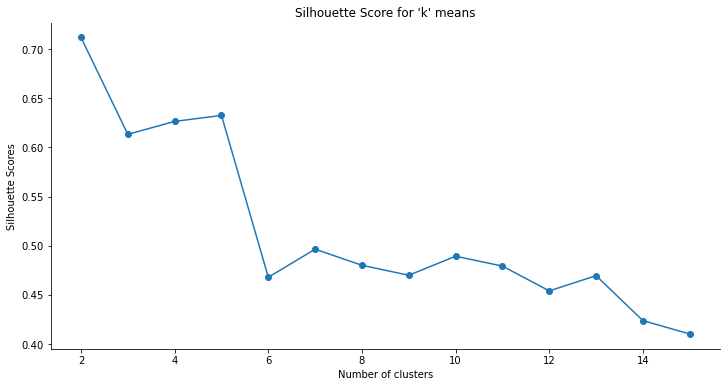

In [21]:

from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def plot(x, y):
    fig = plt.figure(figsize=(12,6))
    plt.plot(x, y, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Scores')
    plt.title('Silhouette Score for \'k\' means')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
maxk = 15
scores = []
kval = []

for k in range(2, maxk+1):
    ny_grouped_clustering = ny_soccer[['lat','lng']]
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=0).fit_predict(ny_grouped_clustering) #Choose any random_state
    
    score = silhouette_score(ny_grouped_clustering, kmeans, metric='euclidean', random_state=0)
    kval.append(k)
    scores.append(score)
    
print(scores)
print(kval)
plot(kval, scores)

Although a cluster of 2 has the best score, a cluster of 3 or 4 is also good. Because NYC is massive, only having 2 clusters will give us very little information on where the best spot is to put a soccer shop. For that reason, the nu,ber of clusters that will be used will be 4.

In [22]:
kclusters = 4

ny_grouped_clustering = ny_soccer[['lat', 'lng']]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 3, 2, 3, 3, 1, 2, 0, 2, 0], dtype=int32)

In [23]:
ny_soccer.insert(0, 'Cluster Labels', kmeans.labels_)
ny_soccer

,Cluster Labels,name,categories,lat,lng,id
0,2,Fords Middle School Soccer Field,Soccer Field,40.541128,-74.322938,4e712365899834bb2a26d7d9
1,3,Jim Brown Field - Manhasset Valley Park,Soccer Field,40.790275,-73.705907,5186b7d7498e9e0ae6102568
2,2,Metuchen Sports Center,Soccer Field,40.533190,-74.373209,56795eb5498ec34bf96c7743
3,3,dutch Broadway park,Soccer Field,40.695271,-73.720352,519903b6498e22092e08daa6
4,3,College Point Soccer Fields,Soccer Field,40.777555,-73.838756,50b1127fe4b073383a7a2954
5,1,Red Bull Practice Field,Soccer Field,40.818904,-74.395983,51976bb5498ec5c559c57fe9
6,2,South Plainfield Soccer Club Field,Soccer Field,40.565939,-74.405550,4d9737d3e07ea35d75fad202
7,0,brookdale park,Soccer Field,40.923278,-74.097123,4f941867e4b03828fe3cfdc6
8,2,Orange ave soccer fields,Soccer Field,40.670474,-74.298429,4fa537d2e4b04e76832ed109
9,0,Pier 40 Soccer Fields,Soccer Field,40.729216,-74.011808,4bff2f9b369476b0ba8a8d1f


In [24]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_soccer['lat'], ny_soccer['lng'], ny_soccer['name'], ny_soccer['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

By observing the map above, it looks like Manhattan is the best spot to put a soccer shop. Let's now figure out which neighborhood in Manhattan would be best.

In [25]:
# Now to find the Sporting Goods Shops

categoryId = '4bf58dd8d48988d1f2941735'
shop_url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&ll={},{}&oauth_token={}&categoryId={}&v={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, ACCESS_TOKEN, categoryId, VERSION, LIMIT)
shop_url

'https://api.foursquare.com/v2/venues/search?&client_id=TIDCTBYJFENFVEDEX531UDZBUQNRPU13XO0WS434TLCSALPC&client_secret=4YXEWQ0NZKOEFN25X3EFDHVVF3ZKE02HDCL1EZPJK4IJ3LNR&ll=40.7127281,-74.0060152&oauth_token=TEF1ULUY3LD1YP0XBLRMGC0GTZ420ONWUR5EFBWCFPXVBMG0&categoryId=4bf58dd8d48988d1f2941735&v=20180604&limit=100'

In [26]:
results_shop = requests.get(shop_url).json()
results_shop

{'meta': {'code': 200, 'requestId': '5ff0e79a043dcc77909bb00c'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 0}}],
 'response': {'venues': [{'id': '58405d42126ae8410b3dcfc7',
    'name': 'adidas',
    'location': {'address': '565 5th Ave',
     'crossStreet': '46th St',
     'lat': 40.756221821894776,
     'lng': -73.97909389823302,
     'labeledLatLngs': [{'label': 'display',
       'lat': 40.756221821894776,
       'lng': -73.97909389823302}],
     'distance': 5347,
     'postalCode': '10017',
     'cc': 'US',
     'neighborhood': 'Midtown East',
     'city': 'New York',
     'state': 'NY',
     'country': 'United States',
     'formattedAddress': ['565 5th Ave (46th St)', 'New York, NY 10017']},
    'categories': [{'id': '4bf58dd8d48988d1f2941735',
      'name': 'Sporting Goods Shop',
      'pluralName': 'Sporting Goods Shops',
      'shortName': 'Sporting Goods',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/sports_outdoors_',
  

In [27]:
shop = results_shop['response']['venues']

# tranform venues into a dataframe
df_shop = json_normalize(shop)
df_shop.head()

<ipython-input-27-01c04179780f>:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df_shop = json_normalize(shop)


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.neighborhood,location.city,location.state,location.country,location.formattedAddress,venuePage.id
0,58405d42126ae8410b3dcfc7,adidas,"[{'id': '4bf58dd8d48988d1f2941735', 'name': 'S...",v-1609623450,False,565 5th Ave,46th St,40.756222,-73.979094,"[{'label': 'display', 'lat': 40.75622182189477...",5347,10017,US,Midtown East,New York,NY,United States,"[565 5th Ave (46th St), New York, NY 10017]",NaN
1,55677a50498e7e597b47194d,Nike Factory Store,"[{'id': '4bf58dd8d48988d1f2941735', 'name': 'S...",v-1609623450,False,2236 Nostrand Ave,btwn Ave H & I,40.630193,-73.947615,"[{'label': 'display', 'lat': 40.6301934, 'lng'...",10427,11210,US,NaN,Brooklyn,NY,United States,"[2236 Nostrand Ave (btwn Ave H & I), Brooklyn,...",NaN
2,53a5f4f0498e1d1f0be9ad8e,NikeLab 21M,"[{'id': '4bf58dd8d48988d1f2941735', 'name': 'S...",v-1609623450,False,21 Mercer St,NaN,40.720812,-74.002043,"[{'label': 'display', 'lat': 40.72081196738455...",960,10013,US,NaN,New York,NY,United States,"[21 Mercer St, New York, NY 10013]",NaN
3,5b4a39e5d03360002c702533,Peloton Madison Avenue,"[{'id': '4bf58dd8d48988d1f2941735', 'name': 'S...",v-1609623450,False,1156 Madison Ave,NaN,40.780830,-73.959381,"[{'label': 'entrance', 'lat': 40.780479, 'lng'...",8540,10028,US,NaN,New York,NY,United States,"[1156 Madison Ave, New York, NY 10028]",NaN
4,568ab43d498e1f6916896f5b,New Balance Factory Store,"[{'id': '4bf58dd8d48988d107951735', 'name': 'S...",v-1609623450,False,651 Kapkowski Rd,NaN,40.659242,-74.170236,"[{'label': 'display', 'lat': 40.65924154909218...",15086,07201,US,NaN,Elizabeth,NJ,United States,"[651 Kapkowski Rd, Elizabeth, NJ 07201]",NaN


In [28]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in df_shop.columns if col.startswith('location.')] + ['id']
dataframe_filtered_shop = df_shop.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered_shop['categories'] = dataframe_filtered_shop.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered_shop.columns = [column.split('.')[-1] for column in dataframe_filtered_shop.columns]

dataframe_filtered_shop

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,neighborhood,city,state,country,formattedAddress,id
0,adidas,Sporting Goods Shop,565 5th Ave,46th St,40.756222,-73.979094,"[{'label': 'display', 'lat': 40.75622182189477...",5347,10017,US,Midtown East,New York,NY,United States,"[565 5th Ave (46th St), New York, NY 10017]",58405d42126ae8410b3dcfc7
1,Nike Factory Store,Sporting Goods Shop,2236 Nostrand Ave,btwn Ave H & I,40.630193,-73.947615,"[{'label': 'display', 'lat': 40.6301934, 'lng'...",10427,11210,US,NaN,Brooklyn,NY,United States,"[2236 Nostrand Ave (btwn Ave H & I), Brooklyn,...",55677a50498e7e597b47194d
2,NikeLab 21M,Sporting Goods Shop,21 Mercer St,NaN,40.720812,-74.002043,"[{'label': 'display', 'lat': 40.72081196738455...",960,10013,US,NaN,New York,NY,United States,"[21 Mercer St, New York, NY 10013]",53a5f4f0498e1d1f0be9ad8e
3,Peloton Madison Avenue,Sporting Goods Shop,1156 Madison Ave,NaN,40.780830,-73.959381,"[{'label': 'entrance', 'lat': 40.780479, 'lng'...",8540,10028,US,NaN,New York,NY,United States,"[1156 Madison Ave, New York, NY 10028]",5b4a39e5d03360002c702533
4,New Balance Factory Store,Shoe Store,651 Kapkowski Rd,NaN,40.659242,-74.170236,"[{'label': 'display', 'lat': 40.65924154909218...",15086,07201,US,NaN,Elizabeth,NJ,United States,"[651 Kapkowski Rd, Elizabeth, NJ 07201]",568ab43d498e1f6916896f5b
5,Foot Locker,Shoe Store,1200 Morris Tpke Ste D226,NaN,40.740260,-74.364300,"[{'label': 'display', 'lat': 40.74026024801413...",30380,07078,US,NaN,Short Hills,NJ,United States,"[1200 Morris Tpke Ste D226, Short Hills, NJ 07...",4c7000efb3ce224bfe6472c6
6,VanMoof New York,Sporting Goods Shop,326 Wythe Ave,NaN,40.715310,-73.964911,"[{'label': 'display', 'lat': 40.71530999999999...",3480,11249,US,NaN,Brooklyn,NY,United States,"[326 Wythe Ave, Brooklyn, NY 11249]",5c512451d69ed0002c9707dc
7,JD Sports,Sporting Goods Shop,1466 Broadway,NaN,40.755476,-73.986181,"[{'label': 'display', 'lat': 40.75547574776189...",5044,10036,US,NaN,New York,NY,United States,"[1466 Broadway, New York, NY 10036]",5df140146043070008d177a0
8,Foot Locker,Shoe Store,1268 Fulton St,NaN,40.680198,-73.950107,"[{'label': 'display', 'lat': 40.68019764853663...",5948,11216,US,NaN,Brooklyn,NY,United States,"[1268 Fulton St, Brooklyn, NY 11216]",4c0983ae6071a5935612de32
9,SKECHERS Retail,Sporting Goods Shop,509 Fifth Avenue,NaN,40.753900,-73.980618,"[{'label': 'display', 'lat': 40.75389982892929...",5059,10017,US,Midtown East,New York,NY,United States,"[509 Fifth Avenue, New York, NY 10017]",562faade498e3ba51c612d86


In [29]:
#filter for 'Sporting Goods Shop' specifically

sport_shop = dataframe_filtered_shop['categories'] == 'Sporting Goods Shop'
ny_shop = dataframe_filtered_shop[sport_shop]
ny_shop = ny_shop.reset_index(drop=True)
ny_shop

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,neighborhood,city,state,country,formattedAddress,id
0,adidas,Sporting Goods Shop,565 5th Ave,46th St,40.756222,-73.979094,"[{'label': 'display', 'lat': 40.75622182189477...",5347,10017,US,Midtown East,New York,NY,United States,"[565 5th Ave (46th St), New York, NY 10017]",58405d42126ae8410b3dcfc7
1,Nike Factory Store,Sporting Goods Shop,2236 Nostrand Ave,btwn Ave H & I,40.630193,-73.947615,"[{'label': 'display', 'lat': 40.6301934, 'lng'...",10427,11210,US,NaN,Brooklyn,NY,United States,"[2236 Nostrand Ave (btwn Ave H & I), Brooklyn,...",55677a50498e7e597b47194d
2,NikeLab 21M,Sporting Goods Shop,21 Mercer St,NaN,40.720812,-74.002043,"[{'label': 'display', 'lat': 40.72081196738455...",960,10013,US,NaN,New York,NY,United States,"[21 Mercer St, New York, NY 10013]",53a5f4f0498e1d1f0be9ad8e
3,Peloton Madison Avenue,Sporting Goods Shop,1156 Madison Ave,NaN,40.780830,-73.959381,"[{'label': 'entrance', 'lat': 40.780479, 'lng'...",8540,10028,US,NaN,New York,NY,United States,"[1156 Madison Ave, New York, NY 10028]",5b4a39e5d03360002c702533
4,VanMoof New York,Sporting Goods Shop,326 Wythe Ave,NaN,40.715310,-73.964911,"[{'label': 'display', 'lat': 40.71530999999999...",3480,11249,US,NaN,Brooklyn,NY,United States,"[326 Wythe Ave, Brooklyn, NY 11249]",5c512451d69ed0002c9707dc
5,JD Sports,Sporting Goods Shop,1466 Broadway,NaN,40.755476,-73.986181,"[{'label': 'display', 'lat': 40.75547574776189...",5044,10036,US,NaN,New York,NY,United States,"[1466 Broadway, New York, NY 10036]",5df140146043070008d177a0
6,SKECHERS Retail,Sporting Goods Shop,509 Fifth Avenue,NaN,40.753900,-73.980618,"[{'label': 'display', 'lat': 40.75389982892929...",5059,10017,US,Midtown East,New York,NY,United States,"[509 Fifth Avenue, New York, NY 10017]",562faade498e3ba51c612d86
7,Swag Shop,Sporting Goods Shop,620 Atlantic Ave,NaN,40.682654,-73.976275,"[{'label': 'display', 'lat': 40.68265392376477...",4184,11217,US,NaN,Brooklyn,NY,United States,"[620 Atlantic Ave, Brooklyn, NY 11217]",5067361ae4b0759e8ab93239
8,Paragon Sports,Sporting Goods Shop,867 Broadway,at E 18th St,40.737637,-73.990163,"[{'label': 'display', 'lat': 40.73763731518360...",3078,10003,US,NaN,New York,NY,United States,"[867 Broadway (at E 18th St), New York, NY 10003]",49e34b16f964a5206f621fe3
9,Nike Factory Store,Sporting Goods Shop,810 Bergen Town Ctr Ste 37,NaN,40.915519,-74.059950,"[{'label': 'display', 'lat': 40.9155192, 'lng'...",23027,07652,US,NaN,Paramus,NJ,United States,"[810 Bergen Town Ctr Ste 37, Paramus, NJ 07652]",4b675494f964a52075482be3


In [30]:
df_sgs = ny_shop[['name', 'categories', 'lat', 'lng', 'id']]
df_sgs.head()

,name,categories,lat,lng,id
0,adidas,Sporting Goods Shop,40.756222,-73.979094,58405d42126ae8410b3dcfc7
1,Nike Factory Store,Sporting Goods Shop,40.630193,-73.947615,55677a50498e7e597b47194d
2,NikeLab 21M,Sporting Goods Shop,40.720812,-74.002043,53a5f4f0498e1d1f0be9ad8e
3,Peloton Madison Avenue,Sporting Goods Shop,40.780830,-73.959381,5b4a39e5d03360002c702533
4,VanMoof New York,Sporting Goods Shop,40.715310,-73.964911,5c512451d69ed0002c9707dc


In [31]:
#Cluster 2 will be filtered out as that is the cluster in and around Manhattan.

cluster = ny_soccer['Cluster Labels'] == 0 #Beware: cluster number can change if restarting cluster
manhattan_soccer= ny_soccer[cluster]
manhattan_soccer = manhattan_soccer.reset_index(drop = True)
manhattan_soccer = manhattan_soccer.drop(['Cluster Labels'], axis = 1)
manhattan_soccer

,name,categories,lat,lng,id
0,brookdale park,Soccer Field,40.923278,-74.097123,4f941867e4b03828fe3cfdc6
1,Pier 40 Soccer Fields,Soccer Field,40.729216,-74.011808,4bff2f9b369476b0ba8a8d1f
2,Hackensack Recreational Fields,Soccer Field,40.894019,-74.035900,4e39f7ed2271ead2c0ebcd39
3,Randalls Island Field 51,Soccer Field,40.788260,-73.926346,4bcb451cfb84c9b678761e3e
4,Sofive Brooklyn,Soccer Field,40.671907,-73.898275,5c184ab293bd63002ca2c7ee
5,Stuy Town Turf Field,Soccer Field,40.732243,-73.977628,516af913498e05225093b48f
6,Stuyvesant Playground 10,Soccer Field,40.732302,-73.977318,4e6b85f6227162c38ee70c9b
7,Kantor Field at Randals Island,Soccer Field,40.784865,-73.925399,4dbc33d14df044e524dd6c91
8,Riverbank State Park Soccer Field,Soccer Field,40.819668,-73.956013,4e1cc7b4ae605fbe0387fdd5
9,Montgomery st soccer field,Soccer Field,40.717498,-74.056803,4f5bb439e4b0d8f7b6478ea9


[0.6988628340565958, 0.4614963179543965, 0.46408866798662324, 0.3793499955489163, 0.3916795732111296, 0.4375482859886801, 0.4569471518887228, 0.45931601062031213, 0.43431138903376615, 0.447988751116808, 0.4505879905103697, 0.45435213246247513, 0.43863369143166137, 0.44239783338376687]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


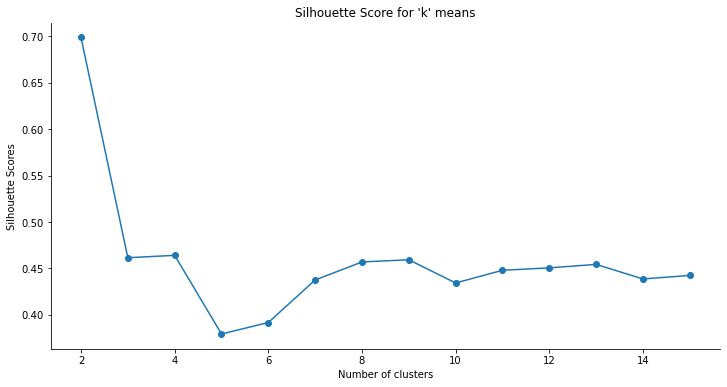

In [32]:
# We will now cluster the above dataframe

def plot(x, y):
    fig = plt.figure(figsize=(12,6))
    plt.plot(x, y, 'o-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Scores')
    plt.title('Silhouette Score for \'k\' means')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
maxk = 15
scores = []
kval = []

for k in range(2, maxk+1):
    manhattan_grouped_clustering = manhattan_soccer[['lat','lng']]
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=0).fit_predict(manhattan_grouped_clustering) #Choose any random_state
    
    score = silhouette_score(manhattan_grouped_clustering, kmeans, metric='euclidean', random_state=0)
    kval.append(k)
    scores.append(score)
    
print(scores)
print(kval)
plot(kval, scores)

4 clusters will be utilized based on the score above.

In [33]:
kclusters = 4

manhattan_grouped_clustering = manhattan_soccer[['lat', 'lng']]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 1, 2, 3, 0, 0, 2, 2, 0], dtype=int32)

In [34]:
manhattan_soccer.insert(0, 'Cluster Labels', kmeans.labels_)
manhattan_soccer.head()

,Cluster Labels,name,categories,lat,lng,id
0,1,brookdale park,Soccer Field,40.923278,-74.097123,4f941867e4b03828fe3cfdc6
1,0,Pier 40 Soccer Fields,Soccer Field,40.729216,-74.011808,4bff2f9b369476b0ba8a8d1f
2,1,Hackensack Recreational Fields,Soccer Field,40.894019,-74.035900,4e39f7ed2271ead2c0ebcd39
3,2,Randalls Island Field 51,Soccer Field,40.788260,-73.926346,4bcb451cfb84c9b678761e3e
4,3,Sofive Brooklyn,Soccer Field,40.671907,-73.898275,5c184ab293bd63002ca2c7ee


In [35]:
manhattan_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_soccer['lat'], manhattan_soccer['lng'], manhattan_soccer['name'], manhattan_soccer['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(manhattan_clusters)
       
manhattan_clusters

This picture shows that the most dense cluster is the cluster south of Central Park. 

In [36]:
# Add Sporting Goods Shops to Manhattan Cluster

map_sgs = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, name in zip(df_sgs['lat'], df_sgs['lng'], df_sgs['name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(manhattan_clusters)  
    
manhattan_clusters

By obseving the above image, the best spot to put a soccer shop would in the Chelsea district near 9th Avenue or in East Village near Avenue B.